## Noise Image plot

In [1]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import cv2

def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann


In [2]:
# get camper data
camper_data = read_json("/opt/ml/input/data/ICDAR17_Korean/ufo/valid_1.json")  # FIXME

# https://pandas.pydata.org/docs/user_guide/merging.html?highlight=group#concatenating-objects
image_names = []
words_dfs = []
words_dfs_1 = []
words = []
for key, value in camper_data['images'].items():
    image_names.append(key)
    words.append(value['words'])
    words_dfs.append(pd.DataFrame(value['words']).T) # words 안에 값들을 Transpose

# dataframe으로 변경 keys + words
df = pd.concat(words_dfs, keys = image_names)

# https://pandas.pydata.org/docs/user_guide/advanced.html
df['image_name'] = df.index.get_level_values(0) # keys index를 가져옴
df['points_id'] = df.index.get_level_values(1).astype(int) # word index를 가져옴

df.index = (_ for _ in range(len(df))) # key값 없앰

legible_df = df.loc[df.illegibility == False] # illegible한 points는 무시합니다.
illegible_df = df.loc[df.illegibility == True] # illegible한 points만 변경합니다.

df

,points,orientation,transcription,word_tags,language,illegibility,image_name,points_id
0,"[[1316.0, 1227], [2691.0, 1242], [2591.0, 1527...",Horizontal,워시엔조이,None,[KO],False,20210918_135753.jpg,0
1,"[[3791.0, 2482.0], [4021.0, 2482.0], [4021.0, ...",None,None,None,None,True,20210918_135753.jpg,1
2,"[[1621.0, 1292], [2281, 1292], [2281, 1677.0],...",Horizontal,흡연,None,[KO],False,20210918_190839.jpg,0
3,"[[1296.0, 1597], [2896.0, 1267], [2961.0, 1537...",Horizontal,Leaflyene,None,[EN],False,20210918_220404.jpg,0
4,"[[1091.0, 1484.5], [1651.0, 1484.5], [1651.0, ...",Horizontal,가회점,None,[KO],False,20210918_221540.jpg,0
...,...,...,...,...,...,...,...,...
5188,"[[1599.0, 2687.83], [1745.67, 2664.5], [1752.3...",Horizontal,everlasting,None,[EN],False,20210111_203928.jpg,179
5189,"[[1755.67, 2664.5], [1864.0, 2636.17], [1869.0...",Horizontal,"moment.""",None,[EN],False,20210111_203928.jpg,180
5190,"[[1991.0, 2651.75], [2496.0, 2651.75], [2496.0...",None,None,None,None,True,20210111_203928.jpg,181
5191,"[[2483.5, 2509.25], [2551.0, 2509.25], [2551.0...",None,None,None,None,True,20210111_203928.jpg,182


### Noise Image 생성

In [3]:
images_valid = df['image_name']

In [4]:
images_valid[0]

'20210918_135753.jpg'

In [15]:
def chk_space_in_word(word):
    if word:
        for spell in word:
            if spell in [' ']:
                return True
    return False

def chk_neg_points(points):
    for x, y in points:
        if x < 0:
            return True
        elif y < 0:
            return True
    return False
    

# image에 points가 아예 없는 경우
_df = pd.DataFrame(camper_data['images']).T
empty_image = set(_df.loc[_df.words == {}].index)

# points는 있지만 text가 없는 경우
empty_transcription_image = legible_df.loc[legible_df.transcription.apply(len) == 0, 'image_name']
empty_transcription_image = set(empty_transcription_image) # illegiblity

# points의 좌표 개수가 홀수인 경우
odd_points_image = df.loc[df.points.apply(len) % 2 != 0, 'image_name']
odd_points_image = set(odd_points_image)

#   text 내에 공백이 포함된 경우
has_space_iamge = df.loc[df.transcription.apply(chk_space_in_word), 'image_name']
has_space_iamge = set(has_space_iamge) # ??
print(len(has_space_iamge))

#   points의 좌표 중 -값을 가지는 경우
neg_potins_image = df.loc[df.points.apply(chk_neg_points), 'image_name']
neg_potins_image = set(neg_potins_image) # -값 -> 0으로 바꾸고 (min, max) illegiblity = true
#print(len(neg_potins_image))
#   points의 좌표 개수가 4 초과인 경우 (Polygon)
# poly_points_image = df.loc[df.points.apply(len) > 4, 'image_name']
# poly_points_image = set(poly_points_image)

# 모든 case들을 고려한 경우
# noisy_image = empty_transcription_image | odd_points_image
noisy_image = has_space_iamge
#noisy_image = illegible_df
noisy_image |= odd_points_image
noisy_image |= neg_potins_image
noisy_image |= empty_image
print(len(noisy_image))
# noisy_image |= poly_points_image

187
515


### Noise Image 출력

In [5]:
def plot_polyBoxes(_ax, image_name, image_dir_path='/opt/ml/input/data/ICDAR17_Korean/images'):
    image_path = f"{image_dir_path}/{image_name}"
    assert Path(image_dir_path).exists(), "이미지 dir 경로를 확인하세요."
    assert Path(image_path).exists(), "이미지 파일명을 확인하세요."
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    anns = df.loc[df.image_name == image_name, 'points']
    
    # 황인재_T2247 캠퍼님 글 참조.
    for ann in anns:
        img = cv2.polylines(img, np.array([ann], dtype=np.int32), True, (73,46,207), 10)
    _ax.imshow(img)
    _ax.axis('off')

def make_annotation(image_name, image_dir_path='/opt/ml/input/data/dataset/images'):
    image_path = f"{image_dir_path}/{image_name}"
    assert Path(image_dir_path).exists(), "이미지 dir 경로를 확인하세요."
    assert Path(image_path).exists(), "이미지 파일명을 확인하세요."

In [6]:
helper = 0

In [12]:
import random
images_valid = list(images_valid)
random.shuffle(images_valid)

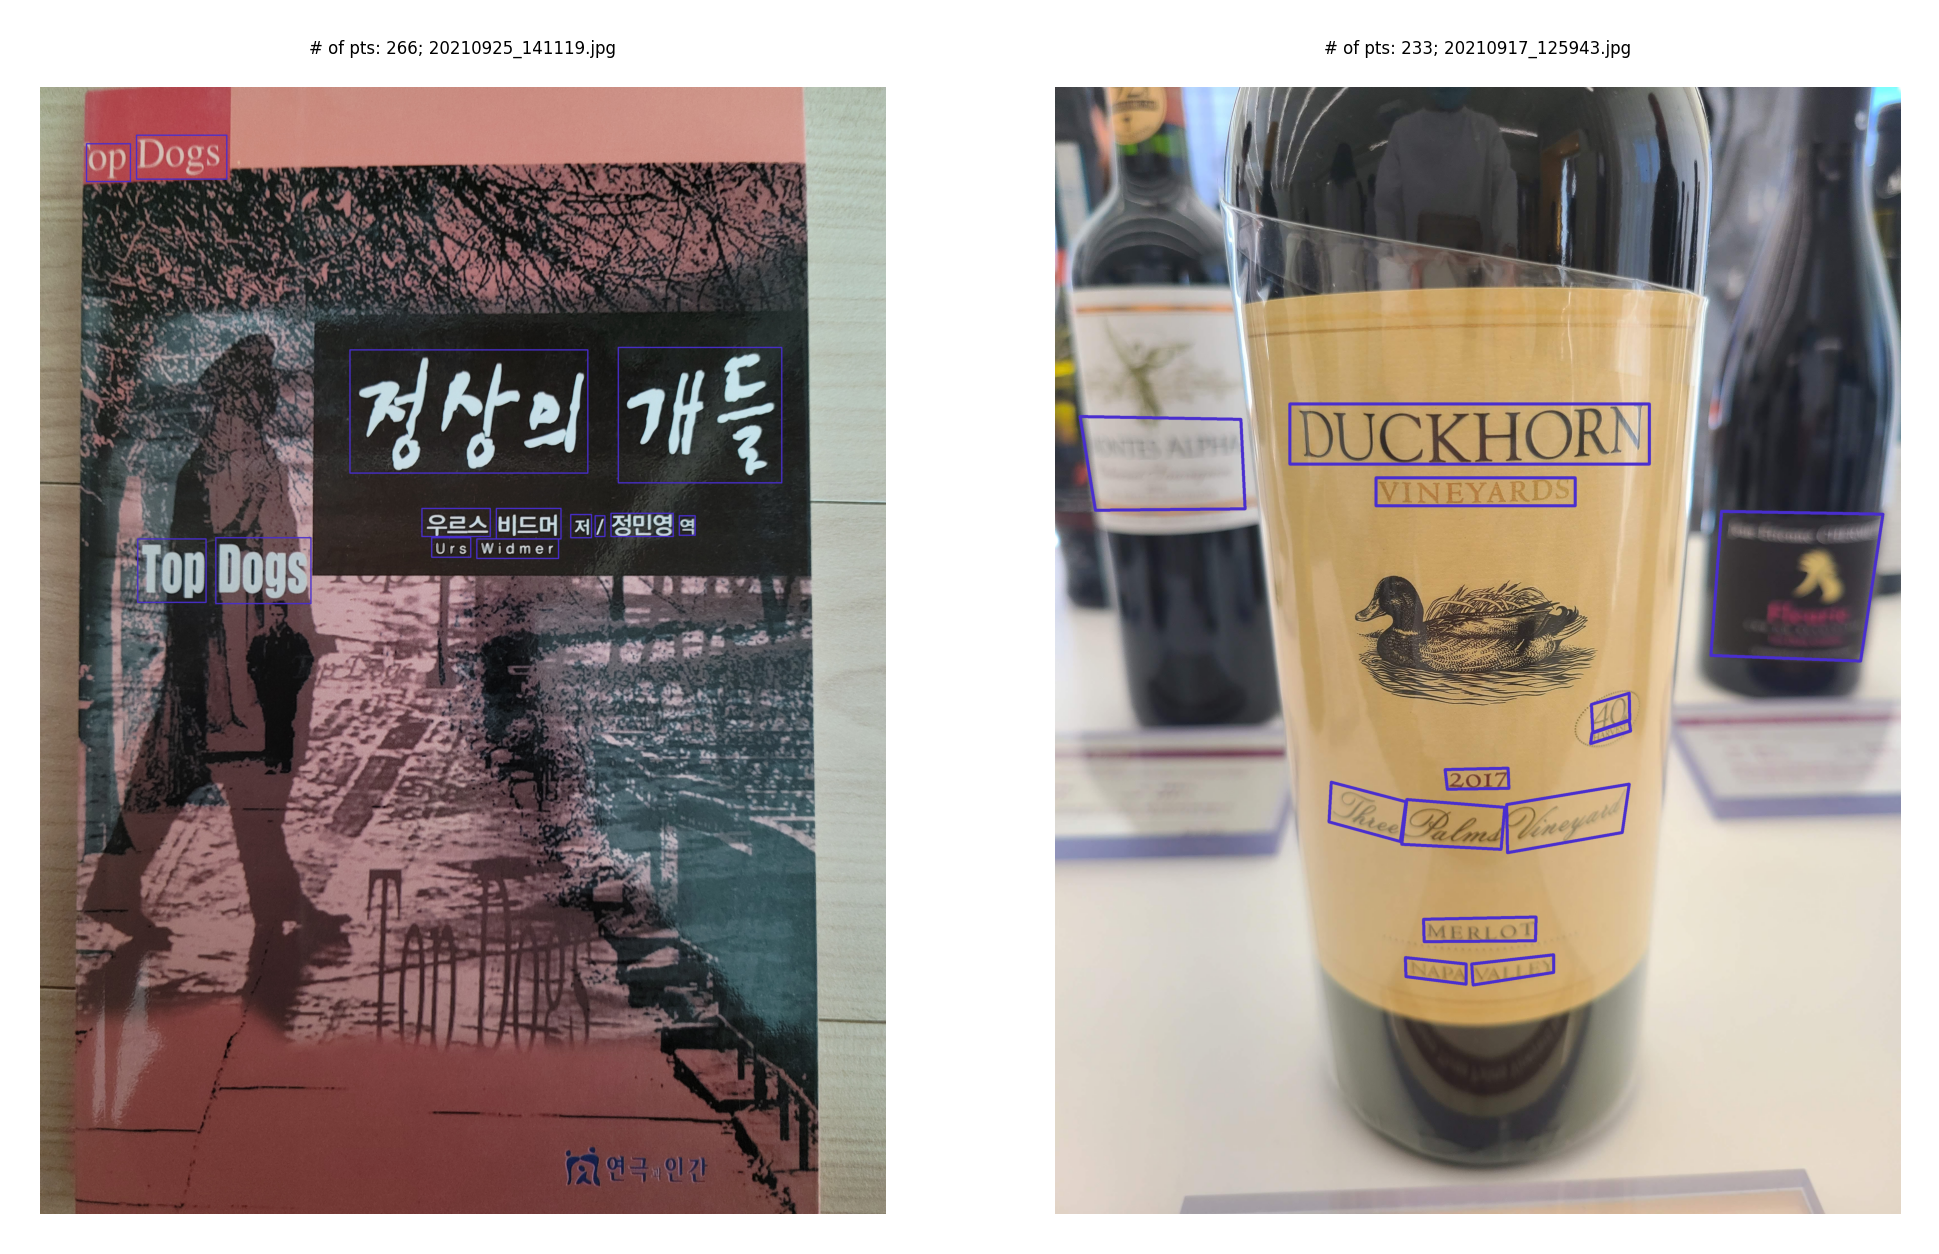

In [23]:
fig, axes = plt.subplots(1, 2, dpi=400)

for i in range(helper, helper+1):
    plot_polyBoxes(axes[0], images_valid[i])
    axes[0].set_title(f'# of pts: 266; {images_valid[i]}', size=3)
    plot_polyBoxes(axes[1], images_valid[i+1])
    axes[1].set_title(f'# of pts: 233; {images_valid[i+1]}', size=3)
helper += 2


## Make Image Dataset without Noisy Image

  - 위에서 만든 Noise Image를 제외한 Camper Image Dataset을 origin dataset에 합쳐주는 코드입니다.
  - `"/opt/ml/input/data/ICDAR17_Korean/images"` 에 Camper Images가 추가됩니다.
  - output은 `train_new.json`을 만듭니다.

In [8]:
# check camper image
print(len(camper_data['images']))

# Delete noisy image
for img_name in list(noisy_image):
    del(camper_data['images'][img_name])

# check camper image without noisy image
print(len(camper_data['images']))

1650
1275


In [9]:
# make_new imgae folder
import os
import shutil
img_dir = "/opt/ml/input/data/ICDAR17_Korean/images" # origin image
camper_dir = "/opt/ml/input/data/dataset/images" # camper image

print(len([i for i in os.listdir(img_dir)])) # check

for img_name in camper_data['images']:
    new_path = os.path.join(img_dir, img_name)
    camper_path = os.path.join(camper_dir, img_name)
    shutil.copyfile(camper_path, new_path) # copy camper image

print(len([i for i in os.listdir(img_dir)])) #check

1811
1811


In [11]:
# Make train_new.json file

with open('../input/data/ICDAR17_Korean/ufo/train.json', 'r') as r:
    origin_data = json.load(r)

print(len(origin_data['images']))
origin_data['images'].update(camper_data['images'])
print(len(origin_data['images']))

with open('../input/data/ICDAR17_Korean/ufo/train_new.json', 'w') as f:
    json.dump(origin_data, f, indent=4)

536
1811
